In [55]:
import numpy as np
from keras.utils.data_utils import get_file
import tarfile
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, RMSprop
from keras.layers import Embedding, Input
import keras.backend as K
from keras.layers import Lambda, Reshape, Dense
from keras.layers import Dot, Flatten, Activation
from keras.models import Model
import matplotlib.pyplot as plt

#Notebook that explores Memory networks.
#In particular we takle the tasks of query answering given a story using the single supporting fact and 
#two supporting facts datasets.



In [2]:
#Gets the file at the provided url and saves it into disk.
path = get_file(
  'babi-tasks-v1-2.tar.gz', 
  origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')

In [3]:
tar = tarfile.open(path)

In [4]:
f_test = tar.extractfile("tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_train.txt")

In [5]:
import re
#Tokenizes a sentence.
def tokenize(s):
    tokens = [word.strip() for word in re.split(r'(\W+)', s)]
    return [word for word in tokens if len(word)>0]

In [6]:
#Untars the dataset file and preprocesses it into lists of word sequences.
def get_stories_from_tar_file(path):
    f = tar.extractfile(path)
    stories = []
    supporting_facts = []
    story = []
    for index, line in enumerate(f):
        #print(line)
        line = line.decode('utf-8').strip()

        split_ind = line.index(" ")
        number = line[:split_ind]
        #print("Number:", number, len(number))
        text = line[split_ind + 1:]

        #print("Number:", number, "Text:", text)

        if(index != 0):
            if((number == "1")):
                #print("Initializing story")
                stories.append(story)
                supporting_facts = []
                story = []
                #print(stories)

        if("\t" in text):
            #Get the question and answer
            question, answer, support = text.split("\t");
            question_tokens = tokenize(question); 
            facts_question_answer = (supporting_facts[:], question_tokens, answer)
            story.append(facts_question_answer)
        else:
            sentence = tokenize(text);
            supporting_facts.append([number] + sentence);
            
    stories.append(story)
            
    return stories;



In [7]:
#Calculates the vocabulary and creates a word to index map
def get_vocabulary_dictionaries(stories):
    words = []
    for story in stories:
        for (facts, question, answer) in story:
            for fact in facts:
                for word in fact:
                    words.append(word);
            for word in question:
                words.append(word);
            words.append(answer);

    #print(words)
    vocabulary = set(words)

    word2idx = {word:index + 1 for index, word in enumerate(vocabulary)}
    word2idx["<P>"] = 0;
    return word2idx;

In [8]:
#Transforms the datasets from lists of words to lists of indexes (at the different list levels)
def transform_to_idx(stories, word2idx):
    story_facts = []
    story_questions = []
    story_answers = []

    for story in stories:

        for (facts, question, answer) in story:
            support_facts_idxs = []
            question_idxs = []
            for fact in facts:
                fact_idxs = []
                #print(fact)
                for word in fact:
                    fact_idxs.append(word2idx[word]);
                support_facts_idxs.append(fact_idxs)

            for word in question:
                question_idxs.append(word2idx[word]);


            story_facts.append(support_facts_idxs)
            story_questions.append(question_idxs)
            story_answers.append(word2idx[answer])
        
    return story_facts, story_questions, story_answers;


In [9]:
#Pads the stories, sentences and questions.
def pad_facts_and_questions(story_facts, story_questions, max_length_story, max_length_fact, max_length_question):
    questions_padded = pad_sequences(story_questions, maxlen = max_length_question)
    facts_padded = []
    for facts in story_facts:
        fact_padded = pad_sequences(facts, maxlen=max_length_fact, padding = "post")
        fact_padded = np.concatenate((fact_padded, np.zeros((max_length_story - len(fact_padded), max_length_fact), dtype = int)))
        facts_padded.append(fact_padded)
    return np.stack(facts_padded), np.array(questions_padded)

In [10]:
SINGLE_SUPPORTING_FACT_FILES = {"train_file": "tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_train.txt",
                               "test_file": "tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_test.txt"}

TWO_SUPPORTING_FACT_FILES = {"train_file": "tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_train.txt",
                               "test_file": "tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_test.txt"}

In [11]:
#Retrieves the dataset correspoing to the single supporting fact task or the two supporting facts task.

def get_task_data_sets(task):
    
    train_stories = get_stories_from_tar_file(task["train_file"])
    test_stories = get_stories_from_tar_file(task["test_file"])

    #Computes the vocabulary available in the train and test sets.
    word2idx = get_vocabulary_dictionaries(train_stories + test_stories)
    #Transforms the texts into indexes given a vocabulary map.
    train_facts, train_questions, train_answers = transform_to_idx(train_stories, word2idx)
    test_facts, test_questions, test_answers = transform_to_idx(test_stories, word2idx)

    max_length_question = max([len(questions) for questions in train_questions + test_questions])
    max_length_story = max([len(facts) for facts in train_facts + test_facts])
    max_length_fact = 0;
    for facts in train_facts + test_facts:
        max_length = max([len(fact) for fact in facts])
        max_length_fact = max(max_length_fact, max_length)

    #Pads the stories, sentences and the sentences.
    train_facts_padded, train_questions_padded = pad_facts_and_questions(train_facts, train_questions, max_length_story, max_length_fact, max_length_question);
    test_facts_padded, test_questions_padded = pad_facts_and_questions(test_facts, test_questions, max_length_story, max_length_fact, max_length_question);
    return (train_facts_padded, train_questions_padded, np.array(train_answers).reshape((-1, 1))), (test_facts_padded, test_questions_padded, np.array(test_answers).reshape((-1, 1))), word2idx

In [93]:
X_train, X_test, word2idx = get_task_data_sets(SINGLE_SUPPORTING_FACT_FILES)
idx2word = {idx:word for word, idx in word2idx.items()}
MAX_VOCABULARY = len(word2idx);
MAX_STORY_LENGTH = X_train[0].shape[1]
MAX_FACT_LENGTH = X_train[0].shape[2]
MAX_QUESTION_LENGTH = X_train[1].shape[1]
MAX_VOCABULARY, MAX_STORY_LENGTH, MAX_FACT_LENGTH, MAX_QUESTION_LENGTH

(32, 10, 8, 4)

In [94]:
#SINGLE SUPPORTING FACT

#Build the model.

EMBEDDING_DIM = 15
input_facts = Input(shape=(MAX_STORY_LENGTH, MAX_FACT_LENGTH))
embeddings = Embedding(MAX_VOCABULARY, EMBEDDING_DIM)
sentences_op = embeddings(input_facts)
sentences_op = Lambda(lambda x: K.sum(x, axis = 2))(sentences_op)


In [95]:
input_question = Input(shape=(MAX_QUESTION_LENGTH, ))
embeddings_question = Embedding(MAX_VOCABULARY, EMBEDDING_DIM)
question_op = embeddings_question(input_question)
question_op = Lambda(lambda x: K.sum(x, axis = 1))(question_op)
question_op = Reshape((1, EMBEDDING_DIM))(question_op)


In [96]:
from keras.layers import Dot, Flatten, Activation, dot
#Create weights using the dot product between the question and the sentences in a story.
weights = Dot(axes = 2)([sentences_op, question_op])
weights = Reshape((MAX_STORY_LENGTH,))(weights) #We can use flatten as well but this way we can control the output dimension.
weights = Activation(activation = "softmax")(weights)
weights = Reshape((MAX_STORY_LENGTH, 1))(weights)


In [97]:
s_relevant = Dot(axes = 1)([sentences_op, weights])
s_relevant = Reshape((EMBEDDING_DIM, ))(s_relevant)

In [98]:
output = Dense(MAX_VOCABULARY, activation = "softmax")(s_relevant)

In [99]:
from keras.models import Model

In [100]:
model = Model(inputs = [input_facts, input_question], outputs = [output])

In [101]:
model.compile(optimizer = Adam(lr = 0.01), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ["accuracy"])
r = model.fit(x = [X_train[0], X_train[1]], 
          y = X_train[2], 
          batch_size = 128, 
          validation_data = ([X_test[0], X_test[1]], X_test[2]), 
          epochs = 5)

Train on 10000 samples, validate on 1000 samples
Epoch 1/5
10000/10000 [==============================] - 1s 113us/step - loss: 1.8341 - acc: 0.3614 - val_loss: 1.1660 - val_acc: 0.6590
Epoch 2/5
10000/10000 [==============================] - 1s 56us/step - loss: 0.4174 - acc: 0.8960 - val_loss: 0.0396 - val_acc: 1.0000
Epoch 3/5
10000/10000 [==============================] - 1s 57us/step - loss: 0.0184 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 1.0000
Epoch 4/5
10000/10000 [==============================] - 1s 57us/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 5/5
10000/10000 [==============================] - 1s 59us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000


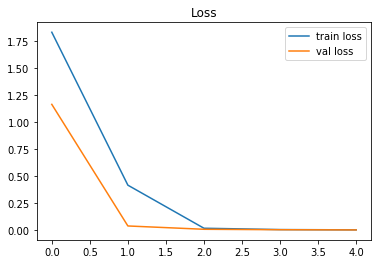

In [102]:
plt.plot(r.history['loss'], label = "train loss");
plt.plot(r.history['val_loss'], label = "val loss");
plt.legend()
plt.title("Loss")
plt.show()

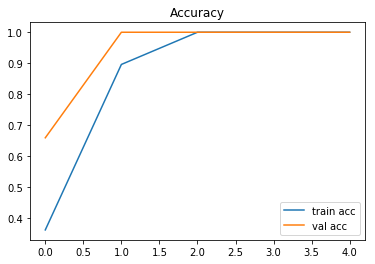

In [103]:
plt.plot(r.history['acc'], label = "train acc");
plt.plot(r.history['val_acc'], label = "val acc");
plt.legend()
plt.title("Accuracy")
plt.show()

In [105]:
#Model to get the calculated weights given a story and a query.
story_weights_model = Model(inputs = [input_facts, input_question], outputs = [weights, output])

In [106]:
#Transform a sequence of word indexes into a word sentence.
def to_text(idxs):
    words = []
    for idx in idxs:
        words.append(idx2word[idx])
    return " ".join(words)    

In [110]:
#Prints a story sample, its query, answer, prediction and weights.

m = len(X_train[0])
while(True):
    print()
    idx = np.random.choice(m)
    story_sample = X_train[0][idx]
    question_sample = X_train[1][idx]
    answer_sample = X_train[2][idx]

    weights_sample, pred_sample = story_weights_model.predict([[story_sample], [question_sample]])
    
    print("Question: ", to_text(question_sample), "Correct:", to_text(answer_sample), "Prediction:", idx2word[np.argmax(pred_sample)])

    print("Story: ")
    for sentence_idxs, weight in zip(story_sample, weights_sample[0]):
        print("{}\t\t\t{:.2f}".format(to_text(sentence_idxs) , weight[0]))
        
    res = input("Continue y/n");
    if(res == "n"):
        break;


Question:  Where is Sandra ? Correct: kitchen Prediction: kitchen
Story: 
1 Mary journeyed to the bedroom . <P>			0.00
2 Sandra travelled to the kitchen . <P>			1.00
<P> <P> <P> <P> <P> <P> <P> <P>			0.00
<P> <P> <P> <P> <P> <P> <P> <P>			0.00
<P> <P> <P> <P> <P> <P> <P> <P>			0.00
<P> <P> <P> <P> <P> <P> <P> <P>			0.00
<P> <P> <P> <P> <P> <P> <P> <P>			0.00
<P> <P> <P> <P> <P> <P> <P> <P>			0.00
<P> <P> <P> <P> <P> <P> <P> <P>			0.00
<P> <P> <P> <P> <P> <P> <P> <P>			0.00
Continue y/nn


In [127]:
#Creates word embeddings for stories (axis = 2) or sentences (axis = 1)
def create_embeddings(x_input, axis, max_vocabulary, embedding_dim):
    embeddings = Embedding(max_vocabulary, embedding_dim)
    x_input = embeddings(x_input)
    #Sum over all word embeddings in a sentence get a single vector representation for a sentence.
    return Lambda(lambda x: K.sum(x, axis = axis))(x_input)

#Creates a hop. 
def hop(embeddings_story, embeddings_question, dense_layer_, max_vocabulary, embedding_dim, max_story_length):
    #Emeddings story will be used to calculate the weights.   
    #Embeddings question will be used to calculate the weights as well

    #Calcuate the weights
    embeddings_question = Reshape((1, embedding_dim))(embeddings_question) #(?, 1, E)
    weights = Dot(axes = 2)([embeddings_story, embeddings_question]) #(?, S, 1)
    weights = Reshape((max_story_length,))(weights) #We can use flatten as well but this way we can control the output dimension.
    weights = Activation(activation = "softmax")(weights) #(?, S)
    weights_norm = Reshape((max_story_length, 1))(weights) #(?, S, 1)
    weights_norm #
    
    #Create second embeddings story to be dotted with the weights.
    embeddings_story_2 = create_embeddings(input_story, 2, max_vocabulary, embedding_dim) #(?, S, E)
    s_relevant = Dot(axes = 1)([embeddings_story_2, weights_norm]) #(?, 1, E)
    s_relevant = Reshape((embedding_dim, ))(s_relevant) #(?, E)
    s_relevant
    
    #Pass the relevant sentence into a dense layer
    output = dense_layer_(s_relevant) #(?, E)
    return embeddings_story_2, weights, output
    

In [132]:
#TWO SUPPORTING FACT MODEL

#Build the model.

#Inputs for the first and second hop

X_train, X_test, word2idx = get_task_data_sets(TWO_SUPPORTING_FACT_FILES)
idx2word = {idx:word for word, idx in word2idx.items()}
MAX_VOCABULARY = len(word2idx);
MAX_STORY_LENGTH = X_train[0].shape[1]
MAX_FACT_LENGTH = X_train[0].shape[2]
MAX_QUESTION_LENGTH = X_train[1].shape[1]
MAX_VOCABULARY, MAX_STORY_LENGTH, MAX_FACT_LENGTH, MAX_QUESTION_LENGTH


(124, 88, 8, 5)

In [133]:
#Create inputs for the story and query.
EMBEDDING_DIM = 30
input_story = Input(shape=(MAX_STORY_LENGTH, MAX_FACT_LENGTH))
input_question = Input(shape=(MAX_QUESTION_LENGTH, ))
embeddings_story = create_embeddings(input_story, 2, MAX_VOCABULARY, EMBEDDING_DIM)  #(?, S, E)
embeddings_question = create_embeddings(input_question, 1, MAX_VOCABULARY, EMBEDDING_DIM) # (?, E)
embeddings_story, embeddings_question

dense_layer = Dense(EMBEDDING_DIM, activation='relu')

In [135]:
#First hop 
embeddings_story_1 , weights_1, output_1 = hop(embeddings_story, 
                                               embeddings_question, 
                                               dense_layer, 
                                               MAX_VOCABULARY, 
                                               EMBEDDING_DIM, 
                                               MAX_STORY_LENGTH)
#(Optimization) Pass the sentence embeddings of the first hop into the second hop
embeddings_story_2 , weights_2, output_2 = hop(embeddings_story_1, 
                                               output_1,
                                               dense_layer, 
                                               MAX_VOCABULARY, 
                                               EMBEDDING_DIM, 
                                               MAX_STORY_LENGTH)
output_softmax = Dense(MAX_VOCABULARY, activation = "softmax")(output_2)

In [136]:
embeddings_story_1, weights_1, output_1

(<tf.Tensor 'lambda_35/Sum:0' shape=(?, 88, 30) dtype=float32>,
 <tf.Tensor 'activation_16/Softmax:0' shape=(?, 88) dtype=float32>,
 <tf.Tensor 'dense_17/Relu:0' shape=(?, 30) dtype=float32>)

In [137]:
input_story, input_question, output_2

(<tf.Tensor 'input_21:0' shape=(?, 88, 8) dtype=float32>,
 <tf.Tensor 'input_22:0' shape=(?, 5) dtype=float32>,
 <tf.Tensor 'dense_17_1/Relu:0' shape=(?, 30) dtype=float32>)

In [143]:
model = Model(inputs = [input_story, input_question], outputs = output_softmax)
model.compile(optimizer = Adam(lr = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ["accuracy"]);

In [144]:
r = model.fit(x = [X_train[0], X_train[1]], y = X_train[2], 
          batch_size = 64, 
          epochs = 50, 
          validation_data=([X_test[0], X_test[1]], X_test[2]))

Train on 10000 samples, validate on 1000 samples
Epoch 1/50
10000/10000 [==============================] - 5s 486us/step - loss: 1.4854 - acc: 0.4061 - val_loss: 1.4916 - val_acc: 0.3950
Epoch 2/50
10000/10000 [==============================] - 4s 392us/step - loss: 1.4364 - acc: 0.4190 - val_loss: 1.4494 - val_acc: 0.4160
Epoch 3/50
10000/10000 [==============================] - 4s 388us/step - loss: 1.3603 - acc: 0.4580 - val_loss: 1.3358 - val_acc: 0.4590
Epoch 4/50
10000/10000 [==============================] - 4s 389us/step - loss: 1.1797 - acc: 0.5429 - val_loss: 0.9880 - val_acc: 0.6290
Epoch 5/50
10000/10000 [==============================] - 4s 391us/step - loss: 0.7915 - acc: 0.7098 - val_loss: 0.6988 - val_acc: 0.7460
Epoch 6/50
10000/10000 [==============================] - 4s 391us/step - loss: 0.6581 - acc: 0.7612 - val_loss: 0.6662 - val_acc: 0.7580
Epoch 7/50
10000/10000 [==============================] - 4s 388us/step - loss: 0.6150 - acc: 0.7759 - val_loss: 0.6818 - v

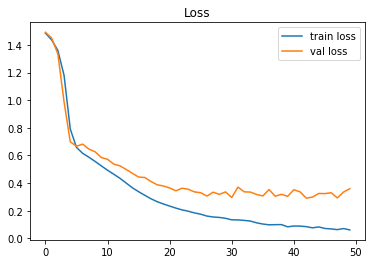

In [145]:
plt.plot(r.history['loss'], label = "train loss");
plt.plot(r.history['val_loss'], label = "val loss");
plt.legend()
plt.title("Loss")
plt.show()

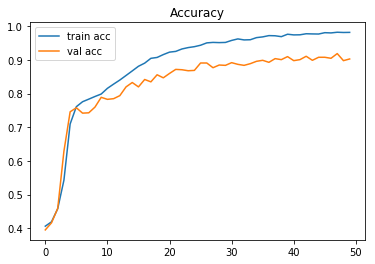

In [146]:
plt.plot(r.history['acc'], label = "train acc");
plt.plot(r.history['val_acc'], label = "val acc");
plt.legend()
plt.title("Accuracy")
plt.show()

In [147]:
#Model to get the calculated weights given a story and a query.
story_weights_model = Model(inputs = [input_story, input_question], outputs = [weights_1, weights_2, output_softmax])

In [148]:
def to_text(idxs):
    words = []
    for idx in idxs:
        words.append(idx2word[idx])
    return " ".join(words) 

In [149]:
#Prints a story sample, its query, answer, prediction and the weights correspoing to both hops. 

m = len(X_train[0])
while(True):
    print()
    idx = np.random.choice(m)
    story_sample = X_train[0][idx]
    question_sample = X_train[1][idx]
    answer_sample = X_train[2][idx]

    weights_1_sample, weights_2_sample, pred_sample = story_weights_model.predict([[story_sample], [question_sample]])
    
    print(np.sum(weights_1_sample[0]), np.sum(weights_2_sample[0]))
    print("Question: ", to_text(question_sample), "Answer:", to_text(answer_sample), "Prediction:", idx2word[np.argmax(pred_sample)])

    print("Story: ")
    for sentence_idxs, weight_1, weight_2 in zip(story_sample, weights_1_sample[0], weights_2_sample[0]):
        print("{}\t\t\t{:.4f}\t\t{:.4f}".format(to_text(sentence_idxs) , weight_1, weight_2))
        
    res = input("Continue y/n");
    if(res == "n"):
        break;


1.0 1.0
Question:  Where is the football ? Answer: garden Prediction: garden
Story: 
1 John moved to the office . <P>			0.0000		0.0000
2 Sandra got the apple there . <P>			0.0000		0.0000
3 Daniel went back to the kitchen .			0.0000		0.0000
4 Sandra left the apple . <P> <P>			0.0000		0.0000
5 Mary picked up the football there .			0.0000		0.0000
6 Sandra took the apple there . <P>			0.0000		0.0000
7 Mary dropped the football there . <P>			0.0000		0.0000
8 John went to the kitchen . <P>			0.0000		0.0000
9 Sandra discarded the apple . <P> <P>			0.0000		0.0000
10 Sandra travelled to the garden . <P>			0.0000		0.0000
11 John went to the hallway . <P>			0.0000		0.0000
12 Daniel journeyed to the hallway . <P>			0.0000		0.0000
13 Sandra went back to the bathroom .			0.0000		0.0000
14 Sandra went to the office . <P>			0.0000		0.0000
15 Sandra took the apple there . <P>			0.0000		0.0000
16 Sandra discarded the apple . <P> <P>			0.0000		0.0000
18 John journeyed to the garden . <P>			0.0000		0.000

Continue y/ny

1.0 1.0
Question:  Where is the milk ? Answer: garden Prediction: garden
Story: 
1 Mary went back to the garden .			0.0000		0.0000
2 Sandra grabbed the milk there . <P>			0.0000		0.0000
3 Sandra left the milk . <P> <P>			0.0000		0.0000
4 Sandra went to the office . <P>			0.0000		0.0000
5 John journeyed to the garden . <P>			0.0000		0.0000
6 Daniel went back to the kitchen .			0.0000		0.0000
7 Mary moved to the hallway . <P>			0.0000		0.0002
8 Sandra took the football there . <P>			0.0000		0.0000
9 Mary got the milk there . <P>			0.0000		0.0000
10 Daniel journeyed to the bathroom . <P>			0.0000		0.0000
11 Mary travelled to the office . <P>			0.0000		0.0093
12 Mary went back to the kitchen .			0.0000		0.0365
14 Daniel went back to the garden .			0.0000		0.0000
15 Sandra moved to the bedroom . <P>			0.0000		0.0000
16 Mary journeyed to the hallway . <P>			0.0000		0.1874
17 Mary dropped the milk there . <P>			0.0895		0.0000
19 Mary picked up the milk there .			0.9105		0.0000


Continue y/nn
